In [1]:
# for EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for prediction models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# plt.style.use("fivethirtyeight")
pal = sns.color_palette()
pal_list = list(pal)

# for image study
import torch
import datetime as dt
import os
import tqdm


#### Import Dataset

In [4]:
items = pd.read_csv('items.csv')
restaurants = pd.read_csv('resturants.csv')
sales = pd.read_csv('sales.csv')

#### Examine the datasets

In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109600 entries, 0 to 109599
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        109600 non-null  object 
 1   item_id     109600 non-null  int64  
 2   price       109600 non-null  float64
 3   item_count  109600 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.3+ MB


In [6]:
sales.date = pd.to_datetime(sales.date)

In [7]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        100 non-null    int64  
 1   store_id  100 non-null    int64  
 2   name      100 non-null    object 
 3   kcal      100 non-null    int64  
 4   cost      100 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 4.0+ KB


In [8]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6 non-null      int64 
 1   name    6 non-null      object
dtypes: int64(1), object(1)
memory usage: 228.0+ bytes


## Merge data to create a single data with date item id, price, item count, item names, kcal values, store id and store name.


In [13]:
print("sales data shape", sales.shape)
print("items data shape", items.shape)
print("restaurants data shape", restaurants.shape)

sales data shape (109600, 4)
items data shape (100, 5)
restaurants data shape (6, 2)


In [18]:
restaurants.value_counts()

id  name          
1   Bob's Diner       1
2   Beachfront Bar    1
3   Sweet Shack       1
4   Fou Cher          1
5   Corner Cafe       1
6   Surfs Up          1
Name: count, dtype: int64

In [223]:
sales.shape

(109600, 4)

In [19]:
merged_data = pd.merge(sales, items, left_on = "item_id", right_on = "id", how = "left")

In [21]:
restaurants.head()

id            name
0   1     Bob's Diner
1   2  Beachfront Bar
2   3     Sweet Shack
3   4        Fou Cher
4   5     Corner Cafe

In [226]:
merged_data.head(2)

date  item_id  price  item_count  id  store_id  \
0 2019-01-01        3  29.22         2.0   3         1   
1 2019-01-01        4  26.42        22.0   4         1   

                              name  kcal   cost  
0                Sweet Fruity Cake   931  29.22  
1  Amazing Steak Dinner with Rolls   763  26.42

In [22]:
data = pd.merge(merged_data, restaurants, left_on = 'store_id', right_on = 'id')

In [23]:
data.head(2)

date  item_id  price  item_count  id_x  store_id  \
0 2019-01-01        3  29.22         2.0     3         1   
1 2019-01-01        4  26.42        22.0     4         1   

                            name_x  kcal   cost  id_y       name_y  
0                Sweet Fruity Cake   931  29.22     1  Bob's Diner  
1  Amazing Steak Dinner with Rolls   763  26.42     1  Bob's Diner

In [26]:
# (data.item_id == data.id_x).all()
# (data.store_id == data.id_y).all()

## rename the columns for easier understanding and drop the duplicate columns

In [27]:
data.rename(columns = {"name_x" : "item_name", "name_y": "restaurant_name"}, inplace = True)

In [28]:
data.drop(columns = ['id_x', 'id_y', 'cost'], inplace = True)

In [29]:
data.head(2)

date  item_id  price  item_count  store_id  \
0 2019-01-01        3  29.22         2.0         1   
1 2019-01-01        4  26.42        22.0         1   

                         item_name  kcal restaurant_name  
0                Sweet Fruity Cake   931     Bob's Diner  
1  Amazing Steak Dinner with Rolls   763     Bob's Diner

# Study overall sales date-wise to understand the sales pattern.

In [31]:
grpd = sales.groupby(['date'])[['item_count']].sum()
grpd

item_count
date                  
2019-01-01       427.0
2019-01-02       337.0
2019-01-03       445.0
2019-01-04       564.0
2019-01-05       552.0
...                ...
2021-12-27       192.0
2021-12-28       344.0
2021-12-29       371.0
2021-12-30       527.0
2021-12-31       817.0

[1096 rows x 1 columns]

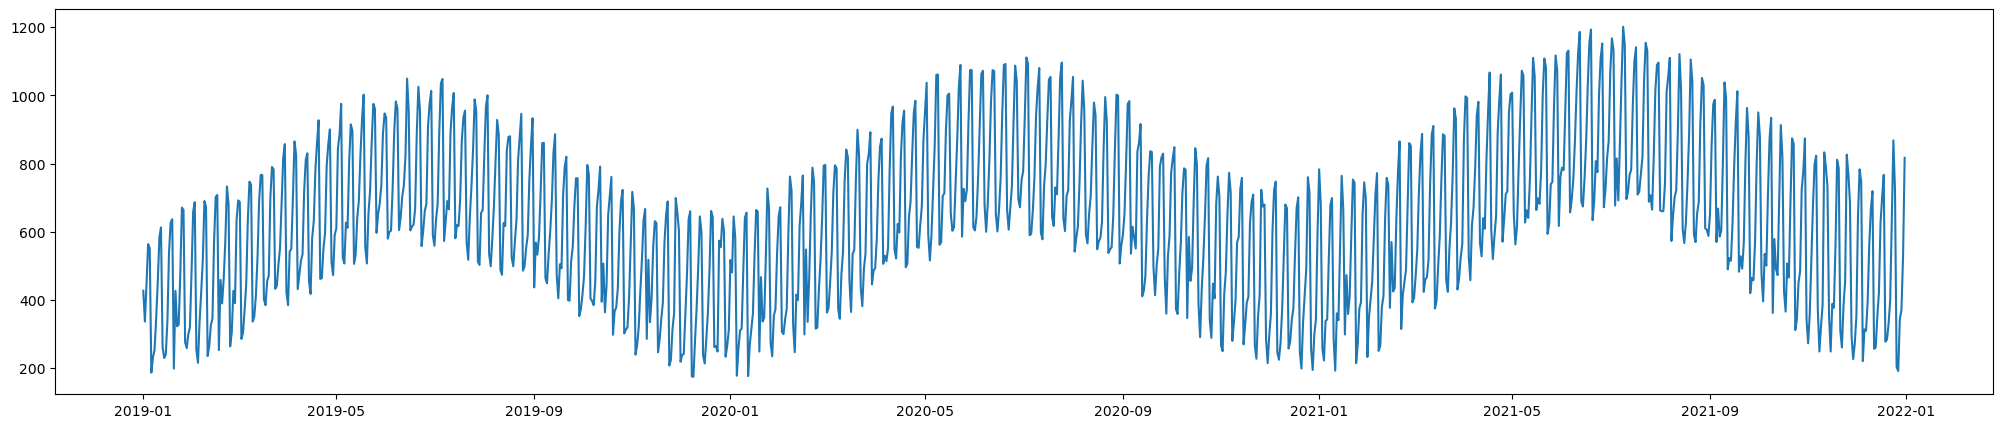

In [32]:
grpd = sales.groupby(['date'])[['item_count']].sum()
plt.figure(figsize = (25,5))
plt.plot(grpd)
plt.show()

## Find out how the sales fluctuate across different days of the week?

In [33]:
data['weekday'] = data.date.dt.day_name()

In [35]:
data['weekday'].unique()

array(['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'Monday'], dtype=object)

In [36]:
import calendar
day_names = list(calendar.day_name)

In [42]:
data.tail()

date  item_id  price  item_count  store_id  \
109595 2021-12-31       49   1.39         0.0         3   
109596 2021-12-31       52   5.68         0.0         3   
109597 2021-12-31       77   7.70         0.0         3   
109598 2021-12-31       81   5.11         0.0         3   
109599 2021-12-31       86   6.50         0.0         3   

                              item_name  kcal restaurant_name weekday  
109595                  Awesome Smoothy    78     Sweet Shack  Friday  
109596  Original Sweet Milky Soft Drink   535     Sweet Shack  Friday  
109597    Blue Ribbon Frozen Milky Cake   636     Sweet Shack  Friday  
109598          Fantastic Milky Smoothy   383     Sweet Shack  Friday  
109599              Original Milky Cake   595     Sweet Shack  Friday

In [38]:
grpd = data.groupby(['weekday'])[['item_count']].sum()
grpd

item_count
weekday              
Friday       136300.0
Monday        70112.0
Saturday     135644.0
Sunday        68032.0
Thursday     116947.0
Tuesday       79454.0
Wednesday     88298.0

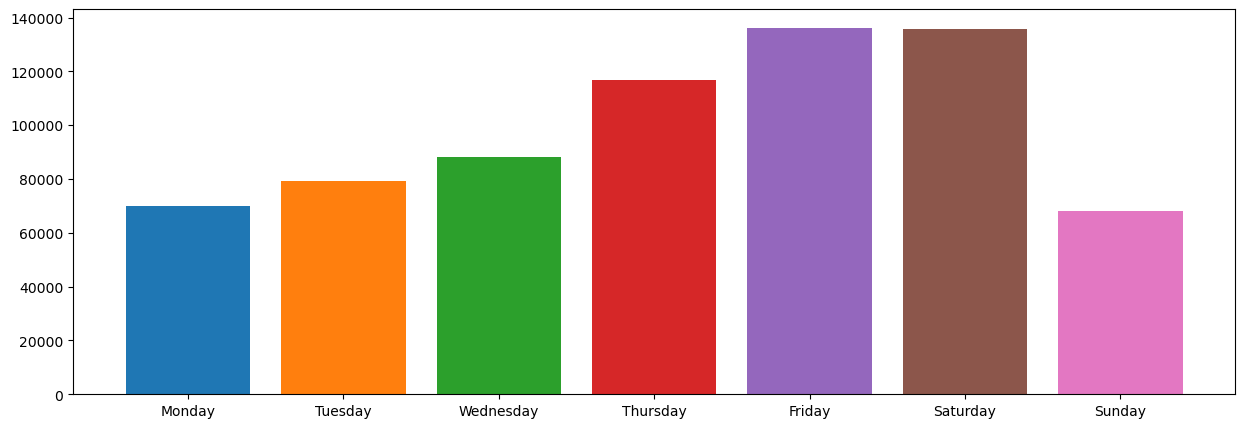

In [37]:
grpd = data.groupby(['weekday'])[['item_count']].sum()
grpd = grpd.loc[day_names].squeeze()
plt.figure(figsize = (15,5))
plt.bar(height = grpd.values, x = grpd.index, color = pal)
plt.show()

## Look for any noticeable trends in the sales data for different months of the year.

In [43]:
data['month_name'] = data.date.dt.month_name()

In [44]:
months = list(calendar.month_name)[1:]

In [45]:
grpd = data.groupby(['month_name'])[['item_count']].sum()
grpd

item_count
month_name            
April          63145.0
August         69502.0
December       41224.0
February       43596.0
January        41270.0
July           77125.0
June           74423.0
March          55137.0
May            73632.0
November       43670.0
October        53403.0
September      58660.0

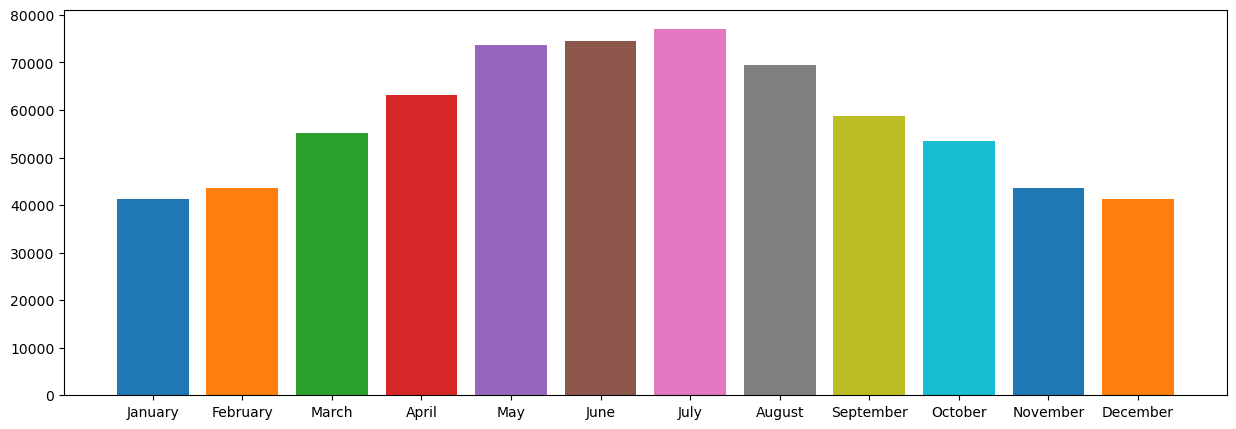

In [46]:
grpd = data.groupby(['month_name'])[['item_count']].sum()
grpd = grpd.loc[months].squeeze()
plt.figure(figsize = (15,5))
plt.bar(height = grpd.values, x = grpd.index, color = pal)
plt.show()

## Examine the distribution of sales across different quarters averaged over years. Identify any noticeablr pattern in sales.


In [47]:
data['quarter'] = data.date.dt.quarter

In [48]:
data.head()

date  item_id  price  item_count  store_id  \
0 2019-01-01        3  29.22         2.0         1   
1 2019-01-01        4  26.42        22.0         1   
2 2019-01-01       12   4.87         7.0         1   
3 2019-01-01       13   4.18        12.0         1   
4 2019-01-01       16   3.21       136.0         1   

                         item_name  kcal restaurant_name  weekday month_name  \
0                Sweet Fruity Cake   931     Bob's Diner  Tuesday    January   
1  Amazing Steak Dinner with Rolls   763     Bob's Diner  Tuesday    January   
2             Fantastic Sweet Cola   478     Bob's Diner  Tuesday    January   
3          Sweet Frozen Soft Drink   490     Bob's Diner  Tuesday    January   
4             Frozen Milky Smoothy   284     Bob's Diner  Tuesday    January   

   quarter  
0        1  
1        1  
2        1  
3        1  
4        1

In [49]:
grpd = data.groupby(['quarter'])[['item_count']].sum().squeeze()
grpd

quarter
1    140003.0
2    211200.0
3    205287.0
4    138297.0
Name: item_count, dtype: float64

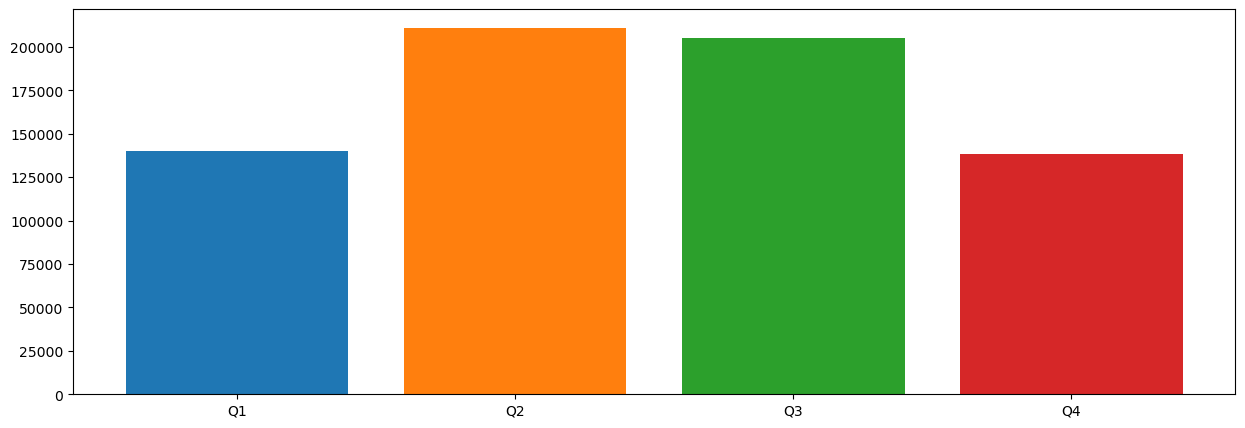

In [50]:
grpd = data.groupby(['quarter'])[['item_count']].sum().squeeze()
plt.figure(figsize = (15,5))
plt.bar(height = grpd.values, x = grpd.index, color = pal)
plt.xticks(range(1,5),["Q"+str(i) for i in range(1,5)])
plt.show()

In [51]:
data['year'] = data.date.dt.year

In [52]:
data['quart-year'] = "Q" + data.quarter.astype(str) + "-" + data.year.astype(str)

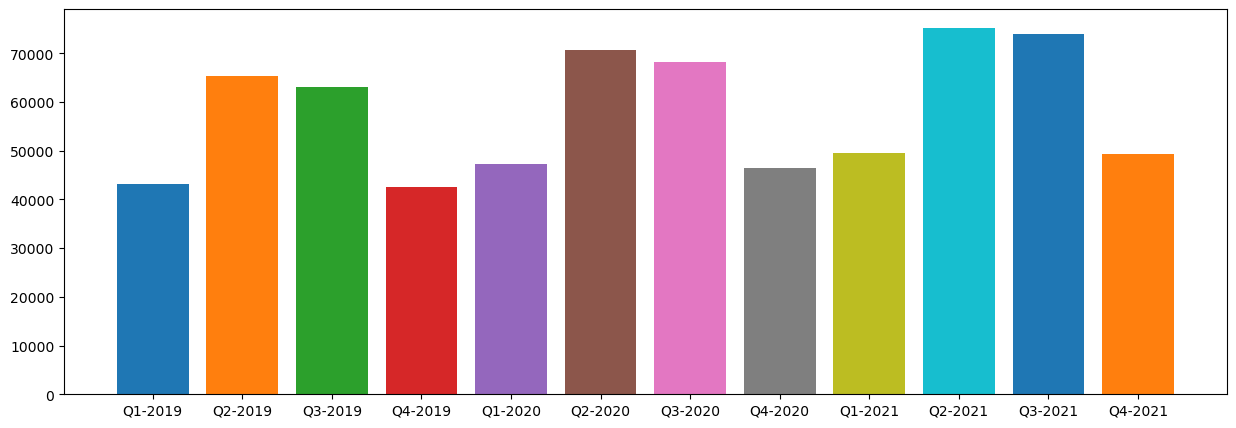

In [53]:
order = ['Q{}-{}'.format(j,i) for i in range(2019, 2022) for j in range(1,5)]
grpd = data.groupby(["quart-year"])[['item_count']].sum()
grpd = grpd.loc[order].squeeze()
plt.figure(figsize = (15,5))
plt.bar(height = grpd.values, x = grpd.index, color = pal)
plt.show()

## Compare the performances of different restaurants.Which restaurant had the most sales? Also study the sales for each restaurant across different years months and days.


In [54]:
data.groupby('store_id')[['item_count']].sum()

item_count
store_id            
1           687527.0
2             1305.0
3             1736.0
4             1106.0
5             1310.0
6             1803.0

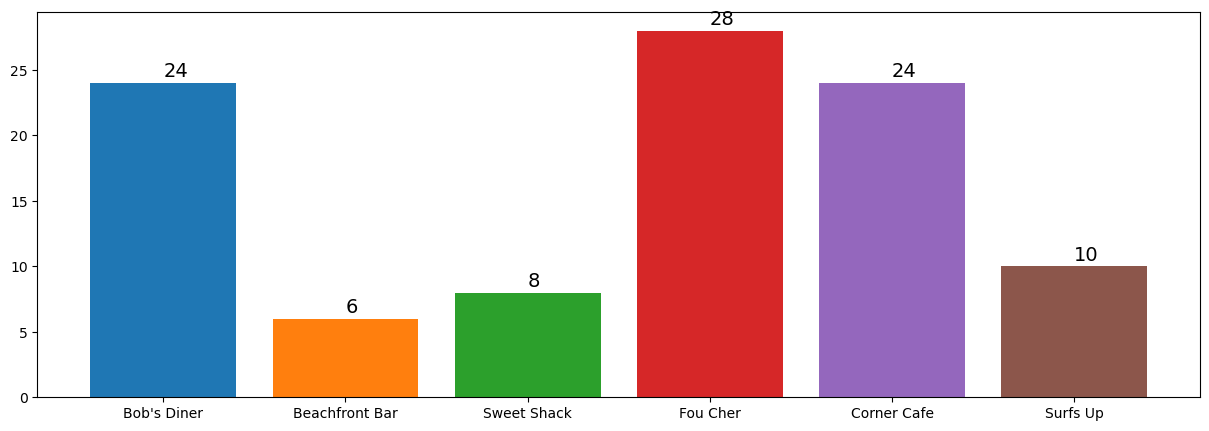

In [55]:
items_served = items.groupby(['store_id']).agg({'id' : "nunique"}).squeeze()
plt.figure(figsize = (15,5))
plt.bar(items_served.index, items_served.values, color = pal)
plt.xticks(range(1,7), restaurants.name)
for i in range(1,7):
  plt.annotate(items_served[i], xy = (i, items_served[i]+0.45), size = 14)

plt.show()

## store wise sales

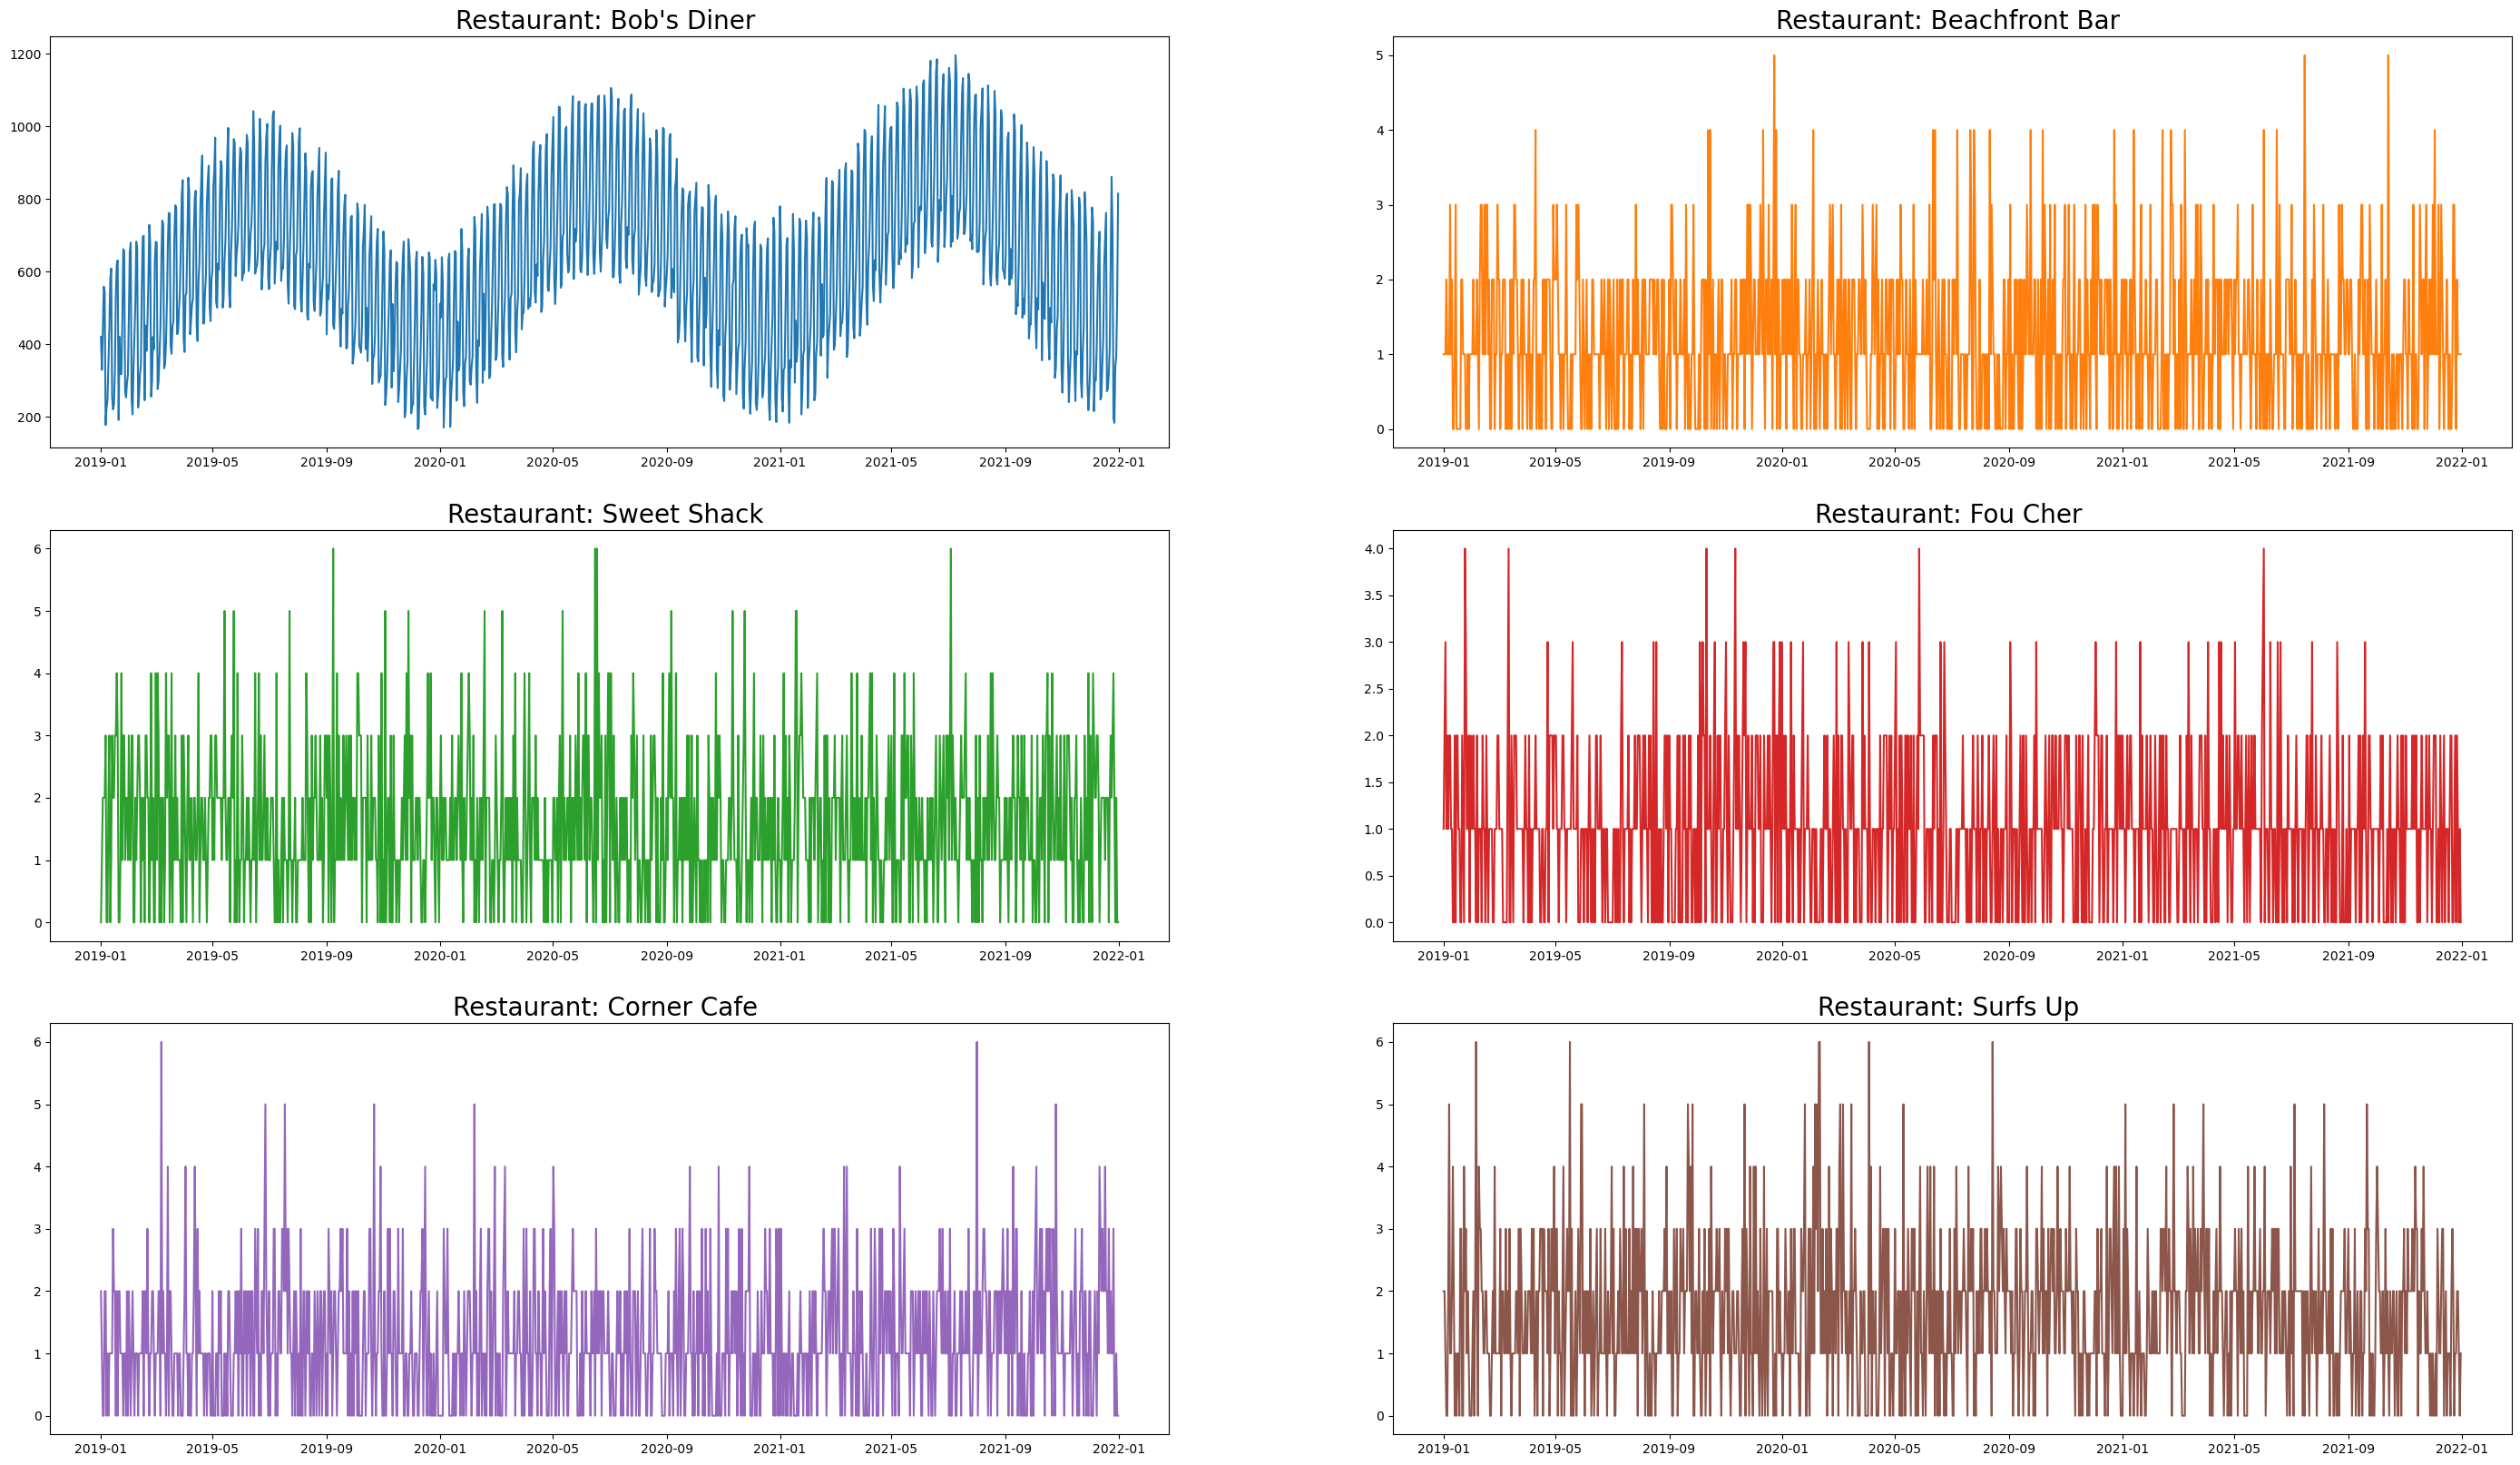

In [56]:
plot_data = data.pivot_table(index = 'date', columns = 'store_id',values = 'item_count', aggfunc = 'sum')
f,ax = plt.subplots(3,2,figsize =(35,20) )
r,c = 0,0
for i in range(1,7):
  ax[r,c].plot(plot_data.loc[:, i], color = pal_list[i-1])
  ax[r,c].set_title('Restaurant: {} '.format(restaurants.loc[restaurants.id == i, 'name'].values[0]), size = 20)
  c += 1
  if c == 2:
    c = 0
    r +=1


# year wise sales for each store

In [57]:
plot_data = data.pivot_table(index = 'quart-year', columns = 'store_id',values = 'item_count', aggfunc = 'sum')
plot_data

store_id          1      2      3      4      5      6
quart-year                                            
Q1-2019     42631.0  111.0  155.0   99.0   99.0  136.0
Q1-2020     46669.0  115.0  139.0   87.0  101.0  167.0
Q1-2021     48888.0  107.0  152.0   91.0  102.0  154.0
Q2-2019     64662.0  102.0  149.0   88.0  103.0  155.0
Q2-2020     70049.0  105.0  153.0   99.0  111.0  137.0
Q2-2021     74678.0  113.0  134.0   99.0  115.0  148.0
Q3-2019     62546.0  103.0  139.0   84.0  121.0  159.0
Q3-2020     67665.0  102.0  135.0   74.0   98.0  167.0
Q3-2021     73299.0  103.0  153.0   82.0  117.0  140.0
Q4-2019     41960.0  123.0  147.0  121.0  100.0  144.0
Q4-2020     45808.0  115.0  127.0   97.0  105.0  156.0
Q4-2021     48672.0  106.0  153.0   85.0  138.0  140.0

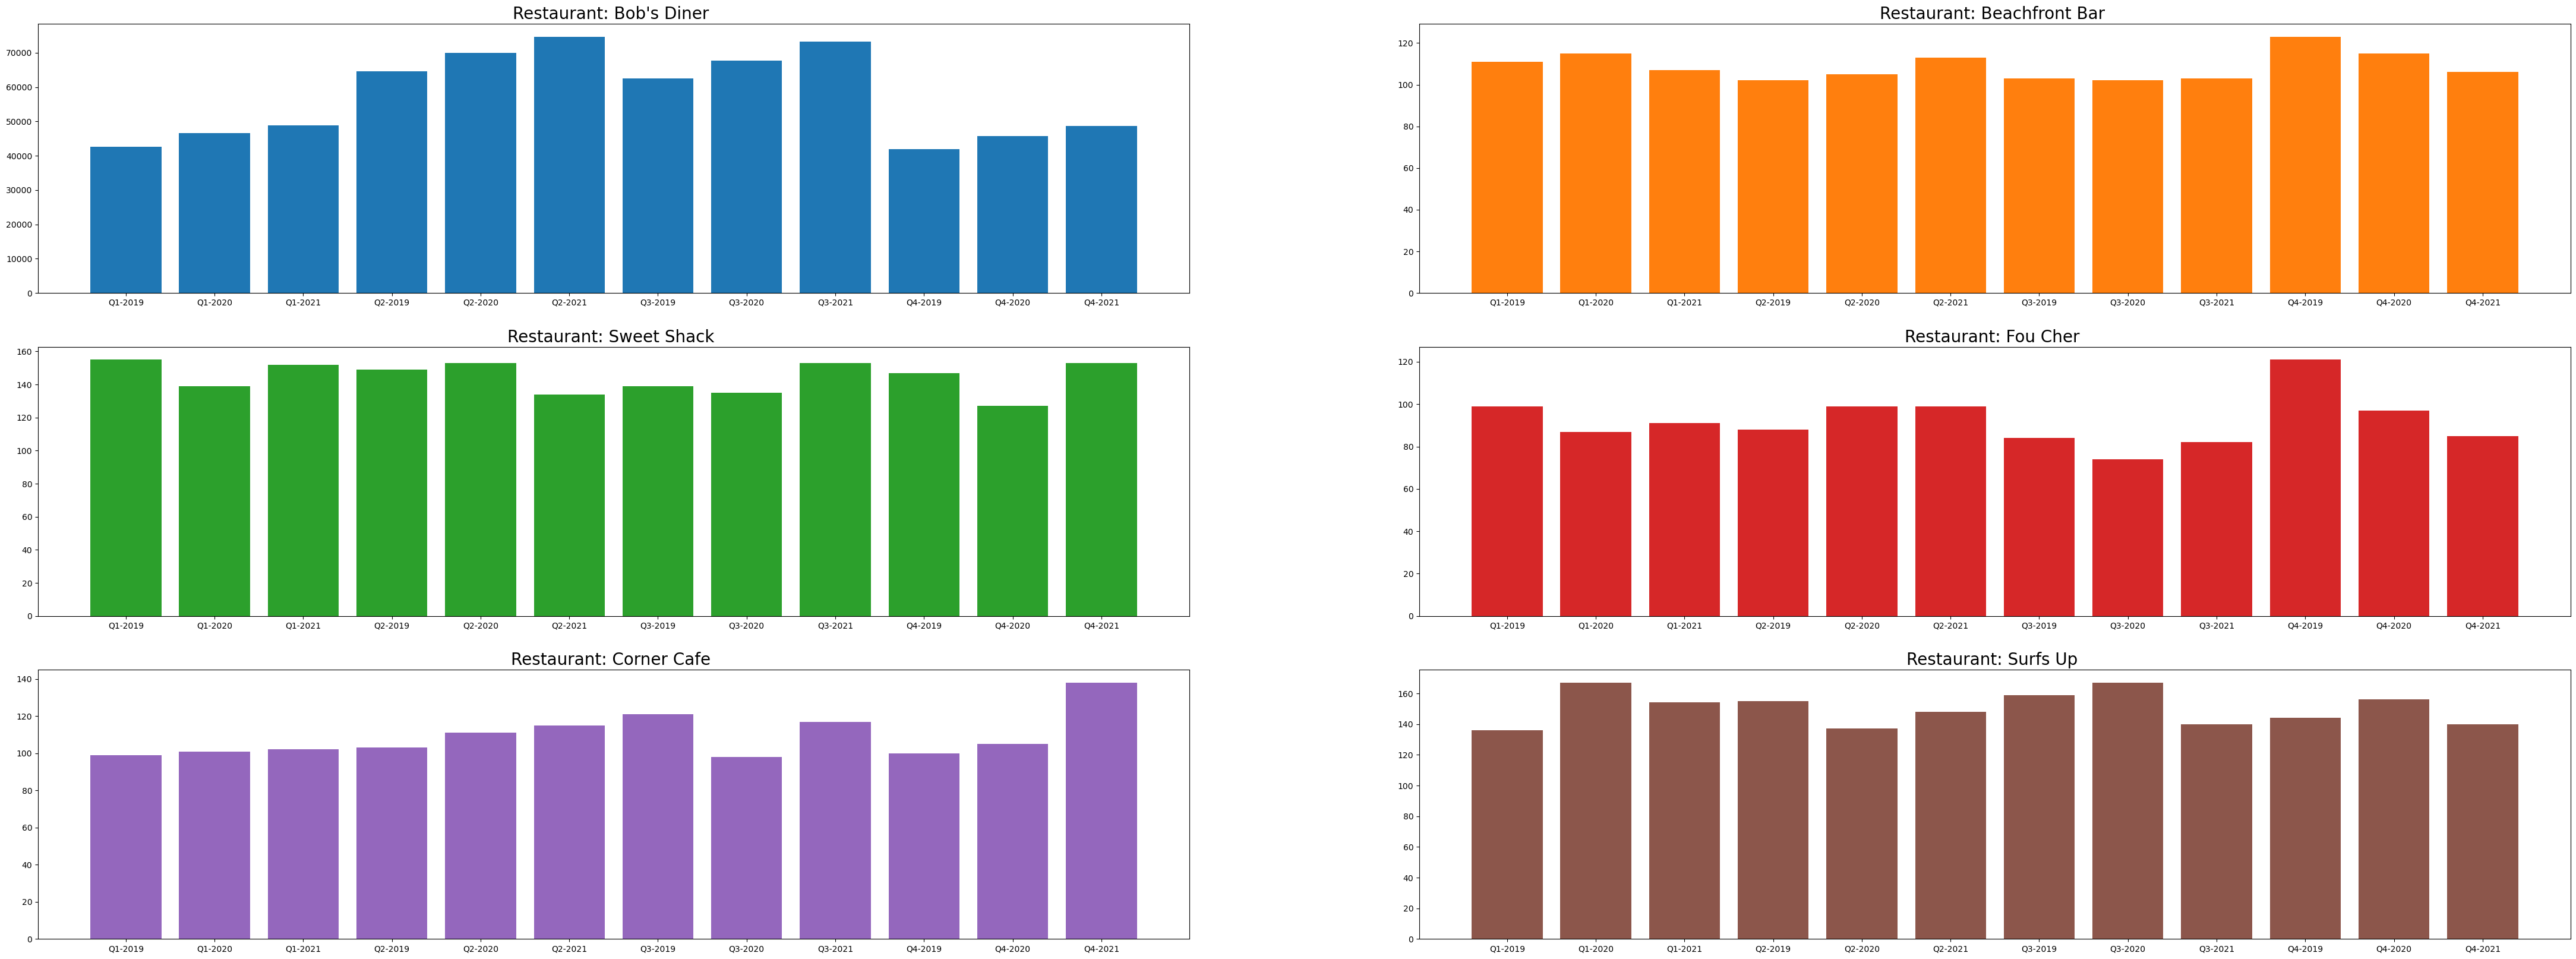

In [58]:
plot_data = data.pivot_table(index = 'quart-year', columns = 'store_id',values = 'item_count', aggfunc = 'sum')
f,ax = plt.subplots(3,2,figsize =(55,20) )
r,c = 0,0
for i in range(1,7):
  ax[r,c].bar(x = plot_data.index,height = plot_data.loc[:, i], color = pal_list[i-1])
  ax[r,c].set_title('Restaurant: {} '.format(restaurants.loc[restaurants.id == i, 'name'].values[0]), size = 20)
  c += 1
  if c == 2:
    c = 0
    r +=1


# Month wise sales

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16884\2619853384.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[r,c].set_xticklabels(labels = months, fontsize = 20)


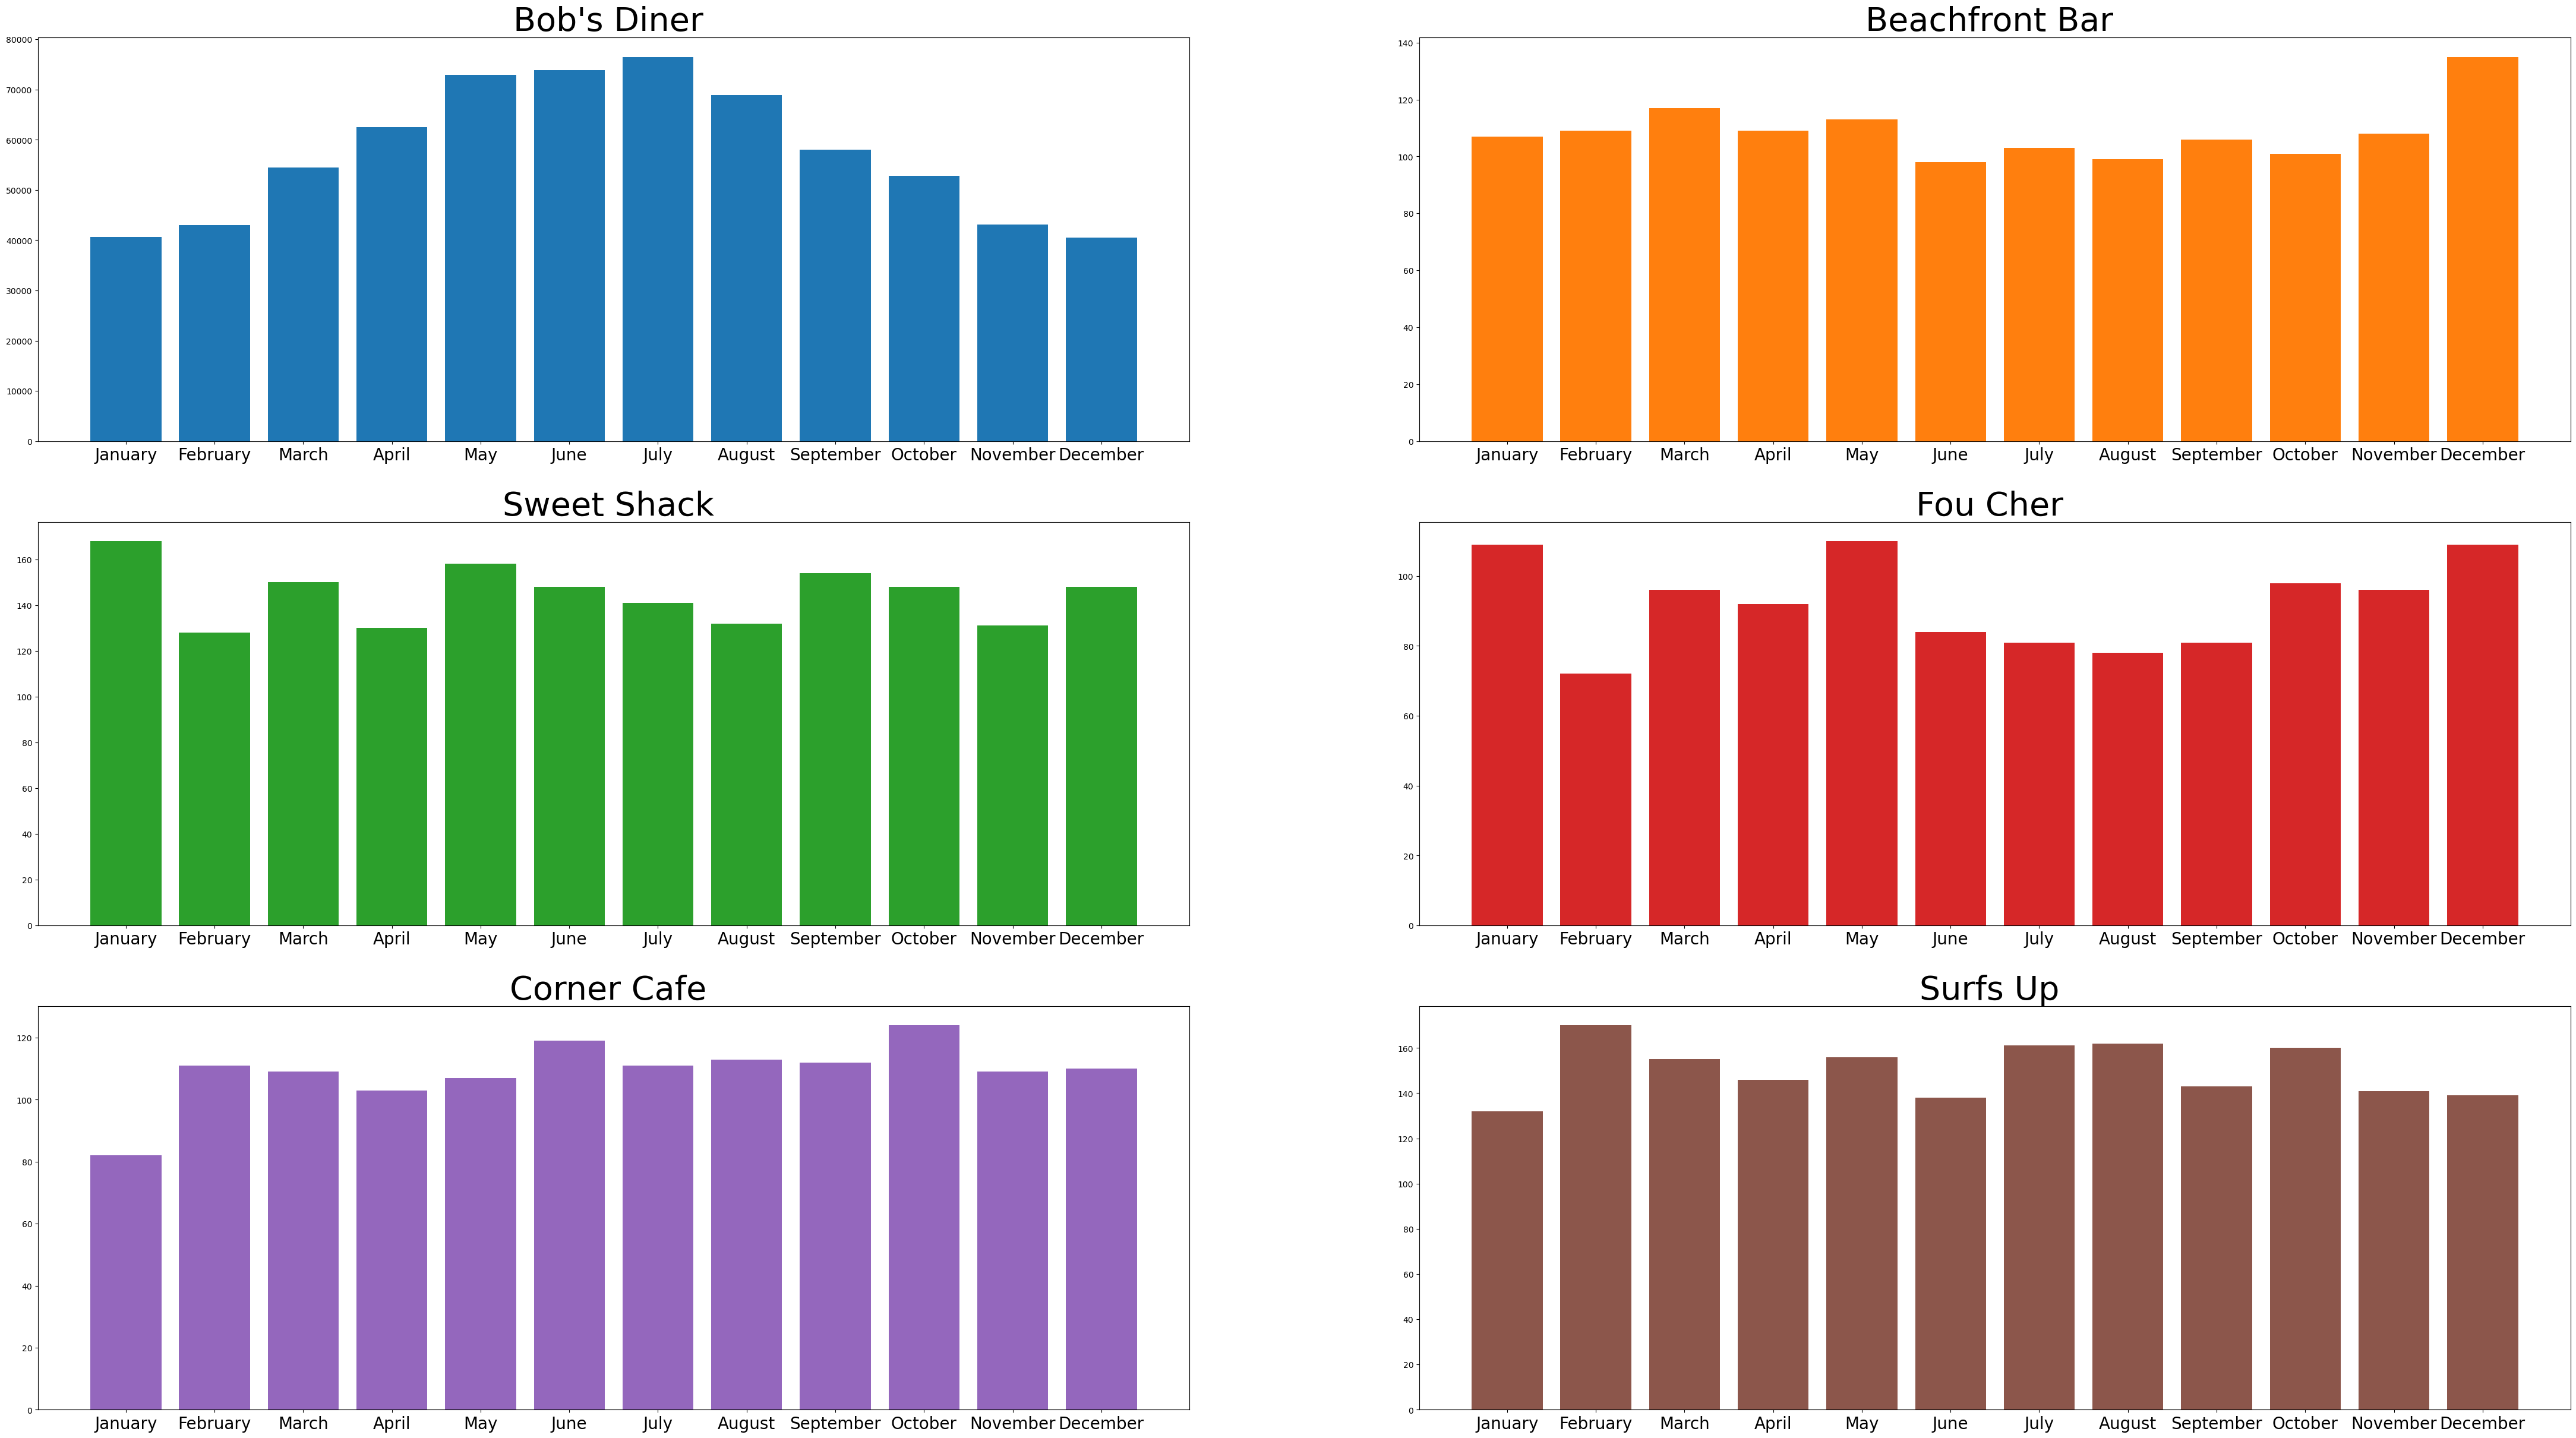

In [59]:
plot_data = data.pivot_table(index = 'month_name', columns = 'store_id',values = 'item_count', aggfunc = 'sum')
plot_data = plot_data.loc[months]
f,ax = plt.subplots(3,2,figsize =(55,30) )
r,c = 0,0
for i in range(1,7):
  ax[r,c].bar(x = plot_data.index,height = plot_data.loc[:, i], color = pal_list[i-1])
  ax[r,c].set_title('{} '.format(restaurants.loc[restaurants.id == i, 'name'].values[0]), size = 40)
  ax[r,c].set_xticklabels(labels = months, fontsize = 20)
  c += 1
  if c == 2:
    c = 0
    r +=1

# Day wise sales

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16884\3239954549.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[r,c].set_xticklabels(labels = day_names, fontsize = 20)


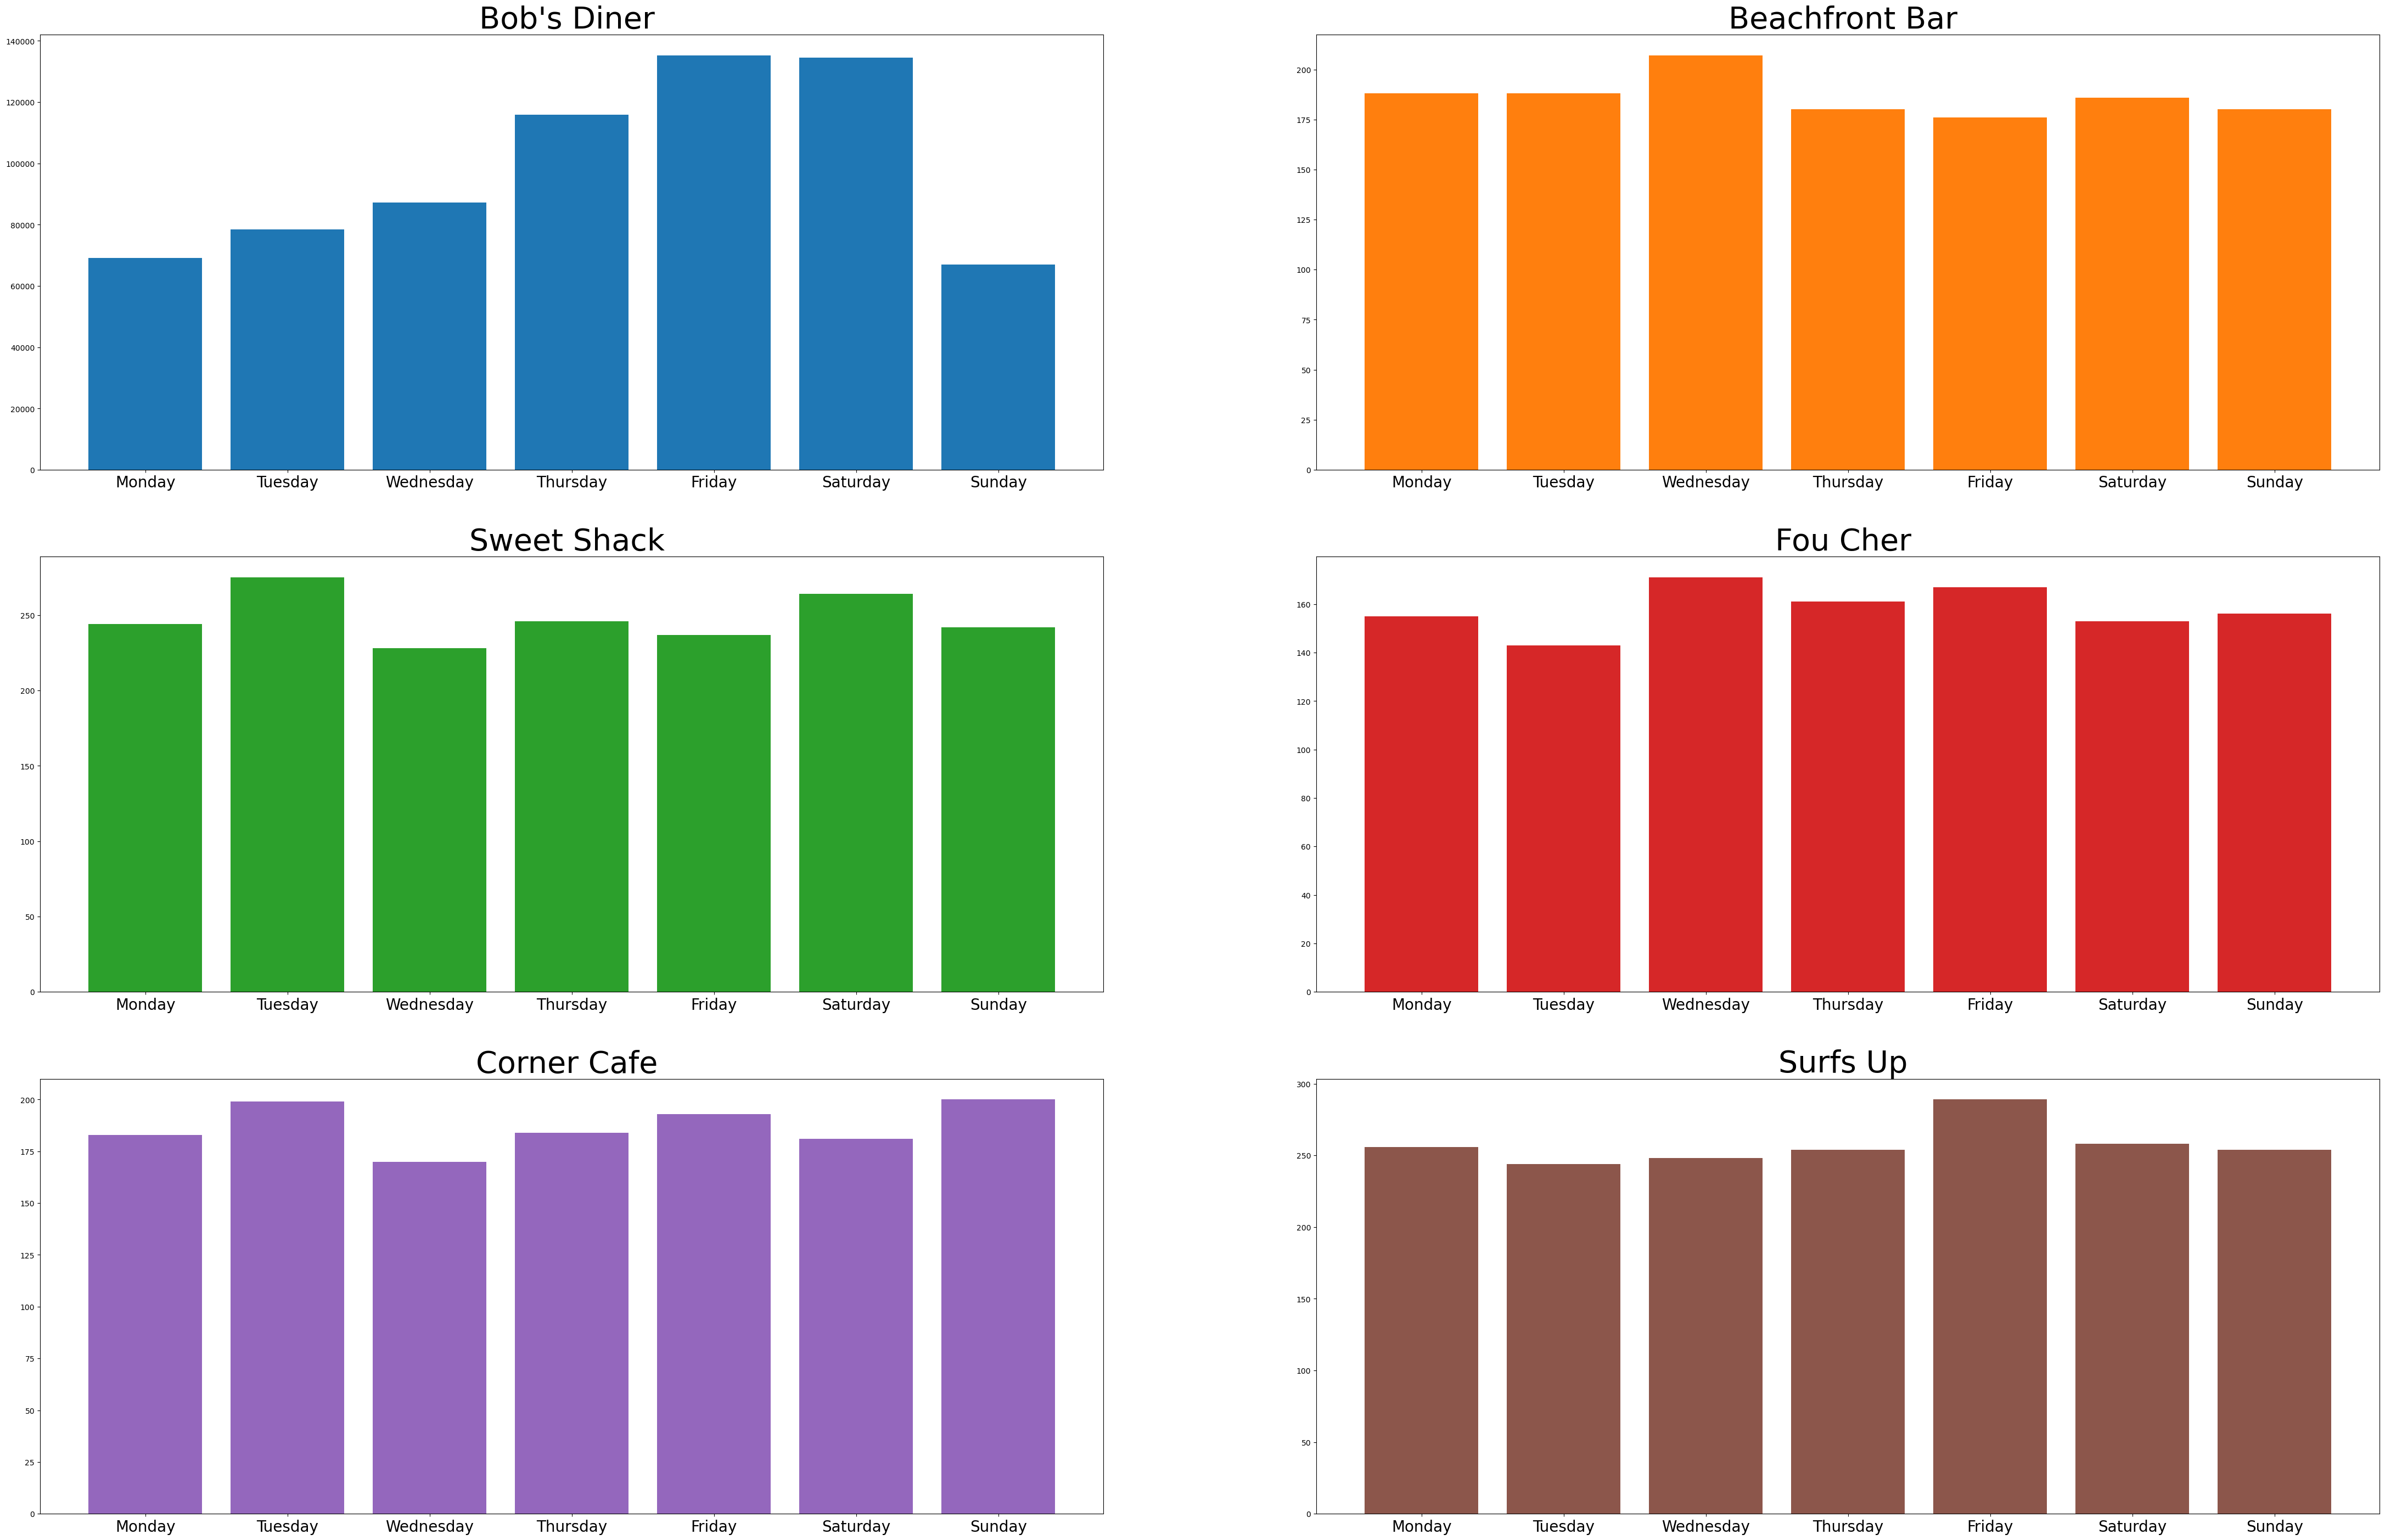

In [60]:
plot_data = data.pivot_table(index = 'weekday', columns = 'store_id',values = 'item_count', aggfunc = 'sum')
plot_data = plot_data.loc[day_names]
f,ax = plt.subplots(3,2,figsize =(55,35) )
r,c = 0,0
for i in range(1,7):
  ax[r,c].bar(x = plot_data.index,height = plot_data.loc[:, i], color = pal_list[i-1])
  ax[r,c].set_title('{} '.format(restaurants.loc[restaurants.id == i, 'name'].values[0]), size = 40)
  ax[r,c].set_xticklabels(labels = day_names, fontsize = 20)
  c += 1
  if c == 2:
    c = 0
    r +=1
plt.show()

# Identify the most popular items overall and the stores where they are being sold. Also find out the most popular item at the store.


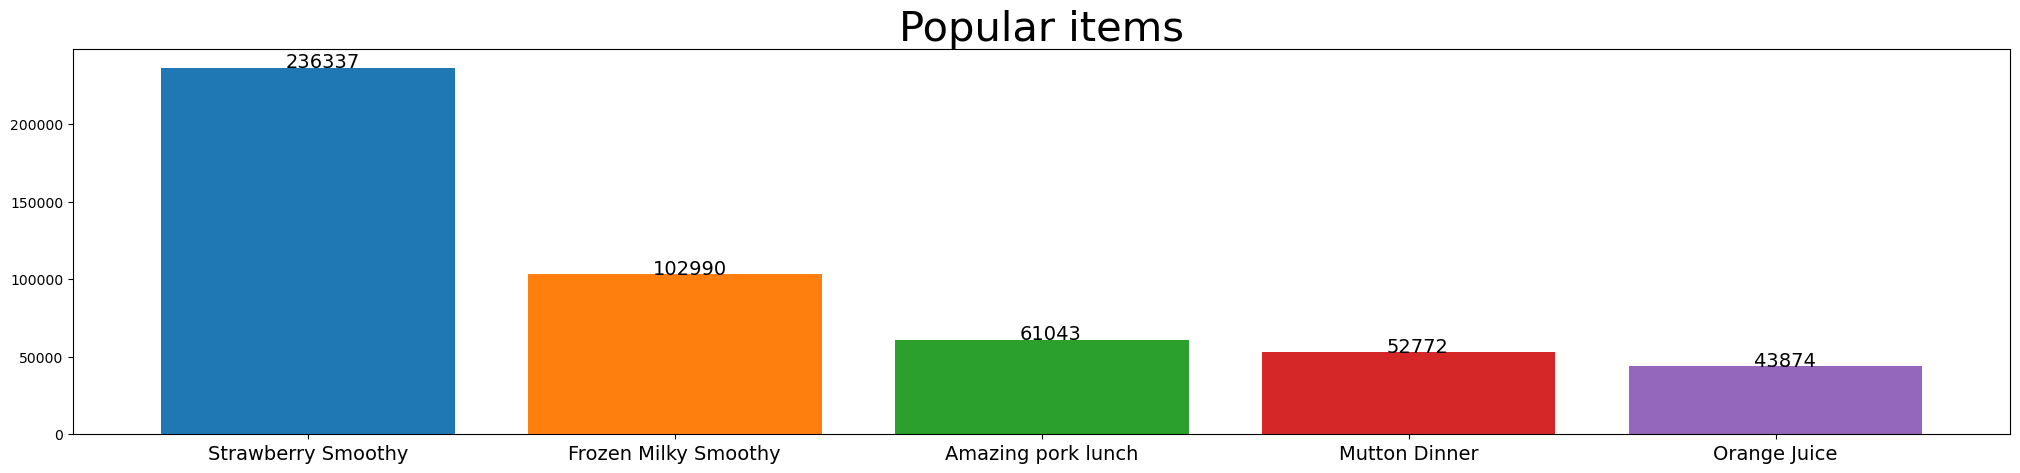

In [61]:
plot_data = data.groupby('item_id')[['item_count']].sum().sort_values('item_count',ascending = False).reset_index()[:5]
final_plot_data = pd.merge(plot_data, items, left_on = 'item_id', right_on = 'id', how = 'left')[['item_id', 'item_count', 'name', 'kcal', 'cost', 'store_id']]
plt.figure(figsize = (25,5))
plt.bar(final_plot_data.name, final_plot_data.item_count, color = pal_list)
plt.title('Popular items', size= 30)
for k in range(5):
  val = final_plot_data.loc[k,'item_count']
  plt.annotate('{:0.0f}'.format(val), xy = (k-0.06, val), size = 14)
plt.xticks(size = 14)
plt.show()

In [63]:
count_data = data.pivot_table(index = 'item_id', columns = 'store_id',values = 'item_count', aggfunc = 'sum', fill_value = 0 )
item_ids = count_data.index[count_data.values.argmax(axis = 0)]


## Popular items restaurant wise

In [64]:
pop_items = items.loc[items.id.isin(item_ids), ['store_id', 'id', 'name', 'kcal', 'cost']]
pop_data = pd.merge(pop_items, restaurants, how = 'left', left_on = 'store_id', right_on = 'id', suffixes = ('_item', '_restaurant'))
pop_data['count'] = count_data.loc[item_ids,].sum(axis = 0).reset_index().iloc[:,1]
pop_data = pop_data[['name_restaurant', 'name_item', 'kcal', 'cost', 'count']]
pop_data

name_restaurant                      name_item  kcal   cost   count
0     Bob's Diner             Strawberry Smoothy   145   2.89  236337
1  Beachfront Bar        Fantastic Milky Smoothy   318   2.91    1147
2     Sweet Shack                Awesome Smoothy    78   1.39    1692
3     Corner Cafe           Frozen Milky Smoothy   211   3.98     298
4        Fou Cher  Blue Ribbon Fruity Vegi Lunch   881  53.98     273
5        Surfs Up             Awesome Soft Drink   248   3.06     997

# Determine if the store with the highest sales volume is also making the most money per day.


In [65]:
data.groupby('store_id')[['item_count']].sum().reset_index()

store_id  item_count
0         1    687527.0
1         2      1305.0
2         3      1736.0
3         4      1106.0
4         5      1310.0
5         6      1803.0

In [66]:
data.pivot_table(index = 'store_id', columns = 'year', values = 'item_count', aggfunc = 'sum')

year          2019      2020      2021
store_id                              
1         211799.0  230191.0  245537.0
2            439.0     437.0     429.0
3            590.0     554.0     592.0
4            392.0     357.0     357.0
5            423.0     415.0     472.0
6            594.0     627.0     582.0

In [67]:
data['sales_amnt'] = data.item_count * data.price

In [68]:
data.head()

date  item_id  price  item_count  store_id  \
0 2019-01-01        3  29.22         2.0         1   
1 2019-01-01        4  26.42        22.0         1   
2 2019-01-01       12   4.87         7.0         1   
3 2019-01-01       13   4.18        12.0         1   
4 2019-01-01       16   3.21       136.0         1   

                         item_name  kcal restaurant_name  weekday month_name  \
0                Sweet Fruity Cake   931     Bob's Diner  Tuesday    January   
1  Amazing Steak Dinner with Rolls   763     Bob's Diner  Tuesday    January   
2             Fantastic Sweet Cola   478     Bob's Diner  Tuesday    January   
3          Sweet Frozen Soft Drink   490     Bob's Diner  Tuesday    January   
4             Frozen Milky Smoothy   284     Bob's Diner  Tuesday    January   

   quarter  year quart-year  sales_amnt  
0        1  2019    Q1-2019       58.44  
1        1  2019    Q1-2019      581.24  
2        1  2019    Q1-2019       34.09  
3        1  2019    Q1-2019       50.16  
4        1  2019    Q1-2019      436.56

In [69]:
data.pivot_table(index = 'store_id', columns = 'year', values = 'sales_amnt', aggfunc = 'sum')

year            2019        2020        2021
store_id                                    
1         1849483.49  2112331.91  2375460.29
2            1281.85     1267.21     1247.14
3             872.59      828.65      877.03
4            9698.80     8590.87     9595.70
5            5292.93     5347.71     5910.79
6            5132.65     5314.43     5204.41

In [70]:
count_order = data.pivot_table(index = 'store_id',  values = 'sales_amnt', aggfunc = 'sum').squeeze()
count_order_rest = count_order.sort_values(ascending = False).index

In [71]:
count_order_rest

Index([1, 4, 5, 6, 2, 3], dtype='int64', name='store_id')

In [72]:
sales_order = data.pivot_table(index = 'store_id',  values = 'item_count', aggfunc = 'sum').squeeze()
sales_order_rest = sales_order.sort_values(ascending = False).index

In [73]:
sales_order_rest

Index([1, 6, 3, 5, 2, 4], dtype='int64', name='store_id')

In [74]:
restaurants

id            name
0   1     Bob's Diner
1   2  Beachfront Bar
2   3     Sweet Shack
3   4        Fou Cher
4   5     Corner Cafe
5   6        Surfs Up

## since restaurant id 1 i.e Bob's Diner has disproportionate data we will leave it out for this analysis to understand that number and sales values match or not for others or not

In [75]:
count_order

store_id
1    6337275.69
2       3796.20
3       2578.27
4      27885.37
5      16551.43
6      15651.49
Name: sales_amnt, dtype: float64

In [76]:
restaurants.set_index('id').loc[count_order_rest]

name
store_id                
1            Bob's Diner
4               Fou Cher
5            Corner Cafe
6               Surfs Up
2         Beachfront Bar
3            Sweet Shack

In [77]:
restaurants.set_index('id').loc[sales_order_rest]

name
store_id                
1            Bob's Diner
6               Surfs Up
3            Sweet Shack
5            Corner Cafe
2         Beachfront Bar
4               Fou Cher

## Bob's Diner is highest grossing in numbers as well as sales value.
## However Fou Cher which is second highest with respect to numbers on the other hand its making least money out of the 6 restaurants

# Identify the most expensive item at each restaurant and find out its calorie count.

In [78]:
items.iloc[[items.cost.argmax()]]

id  store_id                           name  kcal   cost
79  80         4  Blue Ribbon Fruity Vegi Lunch   881  53.98

In [79]:
items.sort_values("cost",ascending = False)[:5]

id  store_id                                               name  kcal  \
79  80         4                      Blue Ribbon Fruity Vegi Lunch   881   
2    3         1                                  Sweet Fruity Cake   931   
55  56         1                    Sea Bass with Vegetables Dinner   613   
96  97         4  Original Fruity Cod with Bread and Vegetables ...   744   
33  34         4                                  Sweet Savory Cake   721   

     cost  
79  53.98  
2   29.22  
55  28.75  
96  28.65  
33  27.47

##  max and min cost of items sold at each restaurant

In [80]:
items.groupby('store_id')[['cost']].agg(['max', 'min', 'mean'])

cost                 
            max   min       mean
store_id                        
1         29.22  2.89  12.211667
2          5.70  2.43   3.585000
3          7.70  1.39   5.276250
4         53.98  3.23  12.819643
5         26.37  3.74  13.371667
6         26.21  3.06  13.970000

## Develop a linear regression, random forest and XGBoost model to predict for the model with the given data. Compare and comment on the results obtained.
- Create required features for development of these models like day of the week, quarter of the year, month, year, day of the month etc.
- Use the last six months data as test data.
- Compute the RMSE values for each of the models to compare their performances.
- Also use these models to forecast for 1 year.


In [81]:
data.date.describe()

count                 109600
mean     2020-07-01 12:00:00
min      2019-01-01 00:00:00
25%      2019-10-01 18:00:00
50%      2020-07-01 12:00:00
75%      2021-04-01 06:00:00
max      2021-12-31 00:00:00
Name: date, dtype: object

In [271]:
ts = data.groupby('date')[['item_count']].sum().squeeze()


In [272]:
data.head()

date  item_id  price  item_count  store_id  \
0 2019-01-01        3  29.22         2.0         1   
1 2019-01-01        4  26.42        22.0         1   
2 2019-01-01       12   4.87         7.0         1   
3 2019-01-01       13   4.18        12.0         1   
4 2019-01-01       16   3.21       136.0         1   

                         item_name  kcal restaurant_name  weekday month_name  \
0                Sweet Fruity Cake   931     Bob's Diner  Tuesday    January   
1  Amazing Steak Dinner with Rolls   763     Bob's Diner  Tuesday    January   
2             Fantastic Sweet Cola   478     Bob's Diner  Tuesday    January   
3          Sweet Frozen Soft Drink   490     Bob's Diner  Tuesday    January   
4             Frozen Milky Smoothy   284     Bob's Diner  Tuesday    January   

   quarter  year quart-year  sales_amnt  
0        1  2019    Q1-2019       58.44  
1        1  2019    Q1-2019      581.24  
2        1  2019    Q1-2019       34.09  
3        1  2019    Q1-2019       50.16  
4        1  2019    Q1-2019      436.56

In [273]:
time_series = data.groupby(['date']).agg({'item_count':'sum', 'weekday': lambda x :x.unique()[0],
                            'quarter' : lambda x :x.unique()[0], 'year': lambda x :x.unique()[0],
                            'month_name' : lambda x :x.unique()[0],
                            'year':lambda x :x.unique()[0]})

# adding some more features : day of the year, day of the month and week of the year

In [274]:
time_series['day_year'] = time_series.index.day_of_year
time_series['day_month'] = time_series.index.day
time_series['week_num'] = time_series.index.isocalendar().week.astype(int)
time_series

item_count    weekday  quarter  year month_name  day_year  \
date                                                                    
2019-01-01       427.0    Tuesday        1  2019    January         1   
2019-01-02       337.0  Wednesday        1  2019    January         2   
2019-01-03       445.0   Thursday        1  2019    January         3   
2019-01-04       564.0     Friday        1  2019    January         4   
2019-01-05       552.0   Saturday        1  2019    January         5   
...                ...        ...      ...   ...        ...       ...   
2021-12-27       192.0     Monday        4  2021   December       361   
2021-12-28       344.0    Tuesday        4  2021   December       362   
2021-12-29       371.0  Wednesday        4  2021   December       363   
2021-12-30       527.0   Thursday        4  2021   December       364   
2021-12-31       817.0     Friday        4  2021   December       365   

            day_month  week_num  
date                             
2019-01-01          1         1  
2019-01-02          2         1  
2019-01-03          3         1  
2019-01-04          4         1  
2019-01-05          5         1  
...               ...       ...  
2021-12-27         27        52  
2021-12-28         28        52  
2021-12-29         29        52  
2021-12-30         30        52  
2021-12-31         31        52  

[1096 rows x 8 columns]

## convert the categorical to numeric using ordinal encoder as here data is ordered in terms of weekday and month name

In [275]:
from sklearn.preprocessing import OrdinalEncoder

In [276]:
day_names

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [277]:
ord_enc = OrdinalEncoder(categories = [months, day_names])
ord_enc.fit(time_series[['month_name', 'weekday']])
time_series[['month_name', 'weekday']] = ord_enc.transform(time_series[['month_name', 'weekday']])

In [278]:
time_series

item_count  weekday  quarter  year  month_name  day_year  \
date                                                                   
2019-01-01       427.0      1.0        1  2019         0.0         1   
2019-01-02       337.0      2.0        1  2019         0.0         2   
2019-01-03       445.0      3.0        1  2019         0.0         3   
2019-01-04       564.0      4.0        1  2019         0.0         4   
2019-01-05       552.0      5.0        1  2019         0.0         5   
...                ...      ...      ...   ...         ...       ...   
2021-12-27       192.0      0.0        4  2021        11.0       361   
2021-12-28       344.0      1.0        4  2021        11.0       362   
2021-12-29       371.0      2.0        4  2021        11.0       363   
2021-12-30       527.0      3.0        4  2021        11.0       364   
2021-12-31       817.0      4.0        4  2021        11.0       365   

            day_month  week_num  
date                             
2019-01-01          1         1  
2019-01-02          2         1  
2019-01-03          3         1  
2019-01-04          4         1  
2019-01-05          5         1  
...               ...       ...  
2021-12-27         27        52  
2021-12-28         28        52  
2021-12-29         29        52  
2021-12-30         30        52  
2021-12-31         31        52  

[1096 rows x 8 columns]

## Generate Test Data

In [279]:
train = time_series[time_series.index < '2021-07-01']
test = time_series[time_series.index >= '2021-07-01']

In [280]:
y_var = 'item_count'
x_vars = time_series.drop(columns = 'item_count').columns

In [281]:
X_train = train[x_vars]
Y_train = train[y_var]
X_test = test[x_vars]
Y_test = test[y_var]

## Linear Regression

In [282]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression()

In [283]:
test['lr_pred'] = lr.predict(X_test)

/tmp/ipykernel_79/3421247276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['lr_pred'] = lr.predict(X_test)


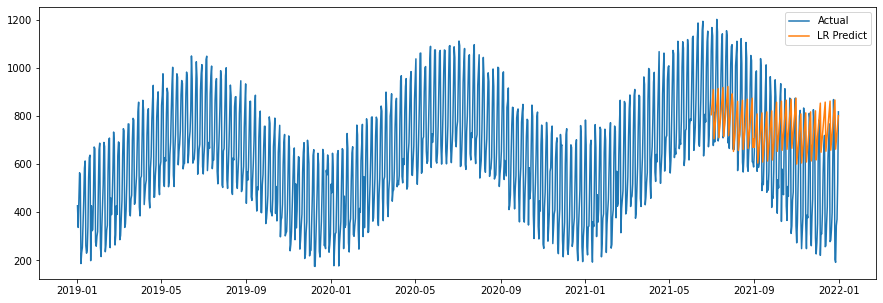

In [284]:
plt.figure(figsize = (15,5))
plt.plot(time_series.item_count, label = "Actual")
plt.plot(test.lr_pred, label = "LR Predict")
plt.legend()
plt.show()

In [285]:
lr_rmse = mean_squared_error(y_true = test.item_count, y_pred = test.lr_pred, squared = False)
lr_mae = mean_absolute_error(y_true = test.item_count, y_pred = test.lr_pred)
lr_r2_score = r2_score(y_true = test.item_count, y_pred = test.lr_pred)
print("Linear Regression :\nRMSE : {:.2f}\nMAE : {:.2f}\nR2_Score : {:.2f}".format(lr_rmse,lr_mae,lr_r2_score*100))

Linear Regression :
RMSE : 244.21
MAE : 196.04
R2_Score : 7.65


In [286]:
results = pd.DataFrame([lr_rmse, lr_mae,lr_r2_score*100], index = ['RMSE', 'MAE', 'R2_Score'], columns = ['Linear Regression']).round(2)
results

Linear Regression
RMSE                 244.21
MAE                  196.04
R2_Score               7.65

# Random Forest

In [287]:
rf = RandomForestRegressor(n_estimators=100, max_depth=20)
rf.fit(X_train, Y_train)

RandomForestRegressor(max_depth=20)

In [288]:
test['rf_pred'] = rf.predict(X_test)

/tmp/ipykernel_79/582745053.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['rf_pred'] = rf.predict(X_test)


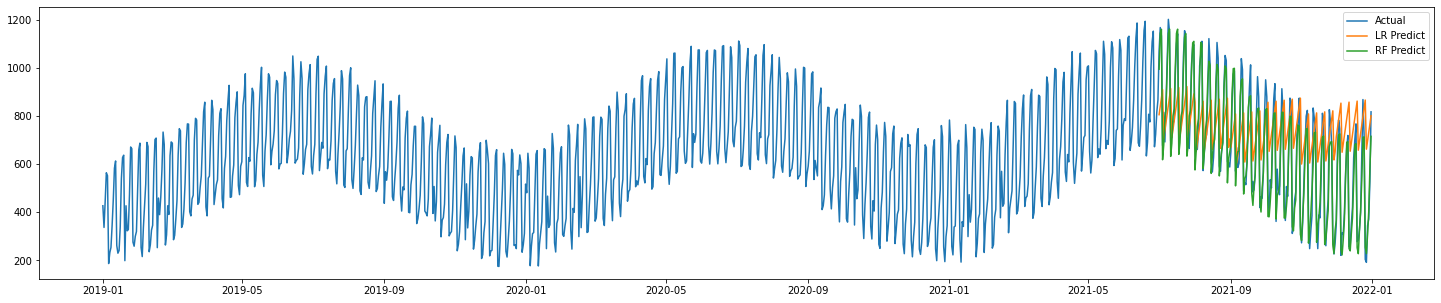

In [289]:
plt.figure(figsize = (25,5))
plt.plot(time_series.item_count, label = "Actual")
plt.plot(test.lr_pred, label = "LR Predict")
plt.plot(test.rf_pred, label = "RF Predict")
plt.legend()
plt.show()

In [290]:
rf_rmse = mean_squared_error(y_true = test.item_count, y_pred = test.rf_pred, squared = False)
rf_mae = mean_absolute_error(y_true = test.item_count, y_pred = test.rf_pred)
rf_r2_score = r2_score(y_true = test.item_count, y_pred = test.rf_pred)
print("Random Forest Regression :\nRMSE : {:.2f}\nMAE : {:.2f}\nR2_Score : {:.2f}".format(rf_rmse,rf_mae,rf_r2_score*100))

Random Forest Regression :
RMSE : 59.91
MAE : 47.48
R2_Score : 94.44


In [291]:
results['Random Forest'] = [rf_rmse,rf_mae,rf_r2_score*100]
results.round(2)

Linear Regression  Random Forest
RMSE                 244.21          59.91
MAE                  196.04          47.48
R2_Score               7.65          94.44

## XGBoost

In [292]:
xgb = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
xgb.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_test, Y_test)],
        verbose=100)

[06:18:27] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:660.07703	validation_1-rmse:709.00433
[100]	validation_0-rmse:262.47899	validation_1-rmse:311.50595
[200]	validation_0-rmse:121.29383	validation_1-rmse:170.69070
[300]	validation_0-rmse:71.46305	validation_1-rmse:106.04091
[400]	validation_0-rmse:52.24712	validation_1-rmse:78.99977
[500]	validation_0-rmse:43.94530	validation_1-rmse:72.72422
[584]	validation_0-rmse:40.41048	validation_1-rmse:73.21955


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

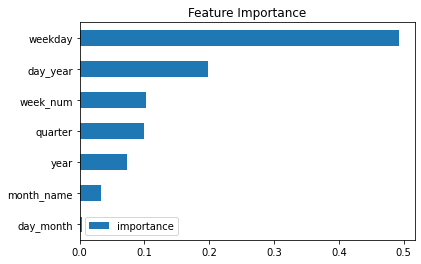

In [293]:
importance = pd.DataFrame(data=xgb.feature_importances_,
             index=xgb.get_booster().feature_names,
             columns=['importance'])
importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [294]:
test['xgb_pred'] = xgb.predict(X_test)

/tmp/ipykernel_79/5488039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['xgb_pred'] = xgb.predict(X_test)


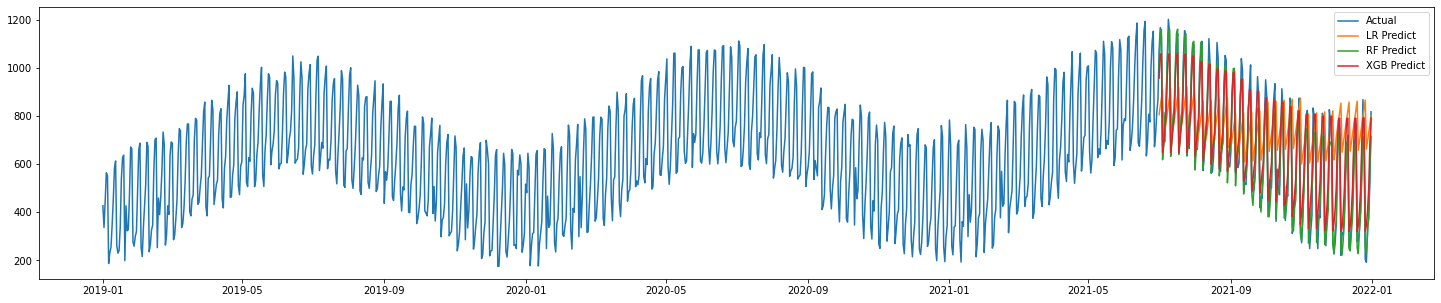

In [295]:
plt.figure(figsize = (25,5))
plt.plot(time_series.item_count, label = "Actual")
plt.plot(test.lr_pred, label = "LR Predict")
plt.plot(test.rf_pred, label = "RF Predict")
plt.plot(test.xgb_pred, label = "XGB Predict")
plt.legend()
plt.show()

In [296]:
xgb_rmse = mean_squared_error(y_true = test.item_count, y_pred = test.xgb_pred, squared = False)
xgb_mae = mean_absolute_error(y_true = test.item_count, y_pred = test.xgb_pred)
xgb_r2_score = r2_score(y_true = test.item_count, y_pred = test.xgb_pred)
print("XGBoost :\nRMSE : {:.2f}\nMAE : {:.2f}\nR2_Score : {:.2f}".format(xgb_rmse,xgb_mae,xgb_r2_score*100))

XGBoost :
RMSE : 72.30
MAE : 59.45
R2_Score : 91.90


In [297]:
results['XGBoost'] = [xgb_rmse,xgb_mae,xgb_r2_score*100]
results = results.round(2)

In [298]:
results

Linear Regression  Random Forest  XGBoost
RMSE                 244.21          59.91    72.30
MAE                  196.04          47.48    59.45
R2_Score               7.65          94.44    91.90

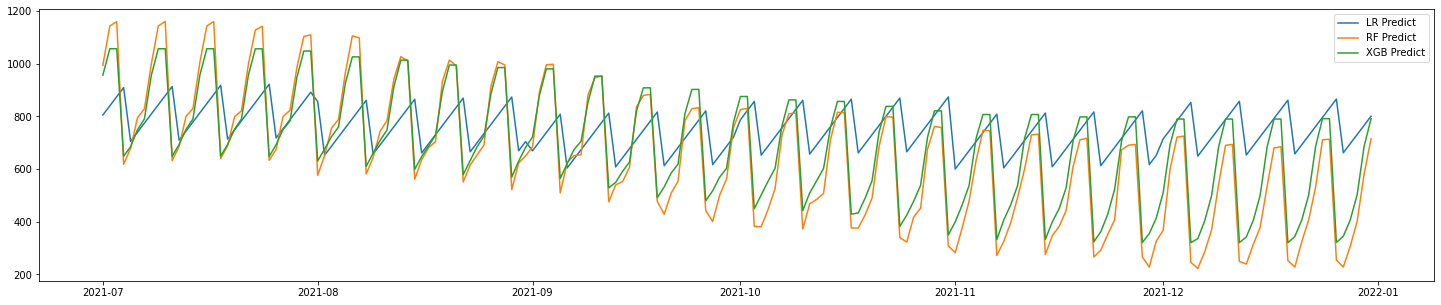

In [299]:
plt.figure(figsize = (25,5))
plt.plot(test.lr_pred, label = "LR Predict")
plt.plot(test.rf_pred, label = "RF Predict")
plt.plot(test.xgb_pred, label = "XGB Predict")
plt.legend()
plt.show()

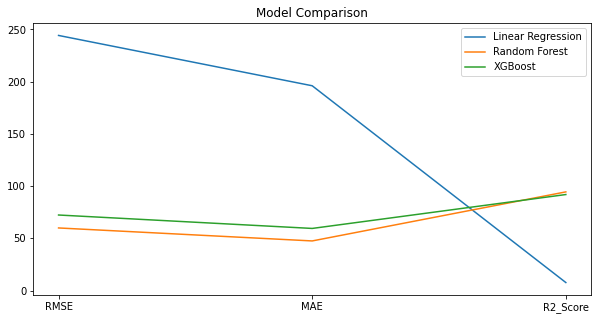

In [300]:
plt.figure(figsize = (10,5))
plt.plot(results['Linear Regression'], label = "Linear Regression")
plt.plot(results['Random Forest'], label = "Random Forest")
plt.plot(results['XGBoost'], label = "XGBoost")
plt.legend(loc = "upper right")
plt.title("Model Comparison")
plt.show()


In [301]:
results

Linear Regression  Random Forest  XGBoost
RMSE                 244.21          59.91    72.30
MAE                  196.04          47.48    59.45
R2_Score               7.65          94.44    91.90

## the best model here is RF : using it for predictions

In [302]:
time_series.index.max()

Timestamp('2021-12-31 00:00:00')

In [303]:
future_predictors = pd.DataFrame(pd.date_range(start="2022-01-01", end="2022-12-31"), columns=['date'])
future_predictors.index = pd.to_datetime(future_predictors.date)


In [304]:
X_train.columns

Index(['weekday', 'quarter', 'year', 'month_name', 'day_year', 'day_month',
       'week_num'],
      dtype='object')

In [305]:
future_predictors.date.dt.isocalendar().week

date
2022-01-01    52
2022-01-02    52
2022-01-03     1
2022-01-04     1
2022-01-05     1
              ..
2022-12-27    52
2022-12-28    52
2022-12-29    52
2022-12-30    52
2022-12-31    52
Name: week, Length: 365, dtype: UInt32

In [306]:
future_predictors['weekday'] = future_predictors.date.dt.day_name()
future_predictors['quarter'] = future_predictors.date.dt.quarter
future_predictors['year'] = future_predictors.date.dt.year
future_predictors['month_name'] = future_predictors.date.dt.month_name()
future_predictors['day_year'] = future_predictors.date.dt.day_of_year
future_predictors['day_month'] = future_predictors.date.dt.day
future_predictors['week_num'] = future_predictors.date.dt.isocalendar().week


In [307]:
future_predictors.head(2)

date   weekday  quarter  year month_name  day_year  \
date                                                                  
2022-01-01 2022-01-01  Saturday        1  2022    January         1   
2022-01-02 2022-01-02    Sunday        1  2022    January         2   

            day_month  week_num  
date                             
2022-01-01          1        52  
2022-01-02          2        52

In [308]:
future_predictors[['month_name', 'weekday']] = ord_enc.transform(future_predictors[['month_name', 'weekday']])

In [309]:
future_predictors['predictions'] = rf.predict(future_predictors[X_train.columns])

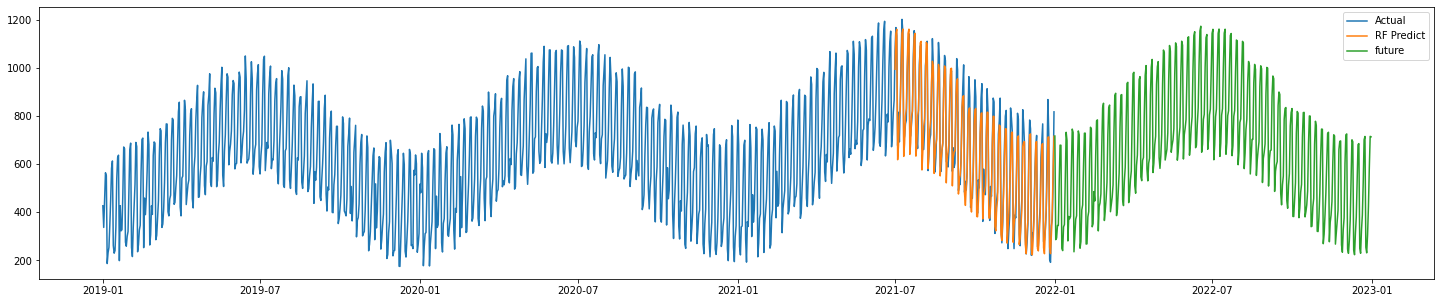

In [310]:
plt.figure(figsize = (25,5))
plt.plot(time_series.item_count, label = "Actual")
plt.plot(test.rf_pred, label = "RF Predict")
plt.plot(future_predictors.predictions, label = "future")
plt.legend()
plt.show()

# Forecasting using Deep Learning


In [311]:
time_ser = data.groupby('date').agg({'sales_amnt': 'sum'})
time_ser

sales_amnt
date                  
2019-01-01     4023.00
2019-01-02     3074.69
2019-01-03     4062.71
2019-01-04     5006.81
2019-01-05     4927.53
...                ...
2021-12-27     1867.71
2021-12-28     3426.50
2021-12-29     3715.39
2021-12-30     5266.27
2021-12-31     8287.81

[1096 rows x 1 columns]

## Define the train and test series

In [312]:
train = time_ser[time_ser.index < '2021-07-01']
test = time_ser[time_ser.index >= '2021-07-01']

## data scaling

In [313]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Generate synthetic data

In [314]:
# We're only using one feature here
n_features = 1
length = 12

In [315]:
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

## Build and train LSTM Model

In [316]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [317]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [318]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

## fit model

In [319]:
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


/tmp/ipykernel_79/3502985036.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


900/900 [==============================] - 4s 3ms/step - loss: 0.0353 - val_loss: 0.0458
Epoch 2/20
900/900 [==============================] - 3s 3ms/step - loss: 0.0161 - val_loss: 0.0178
Epoch 3/20
900/900 [==============================] - 3s 3ms/step - loss: 0.0105 - val_loss: 0.0093
Epoch 4/20
900/900 [==============================] - 3s 3ms/step - loss: 0.0087 - val_loss: 0.0083
Epoch 5/20
900/900 [==============================] - 3s 3ms/step - loss: 0.0081 - val_loss: 0.0075
Epoch 6/20
900/900 [==============================] - 3s 3ms/step - loss: 0.0080 - val_loss: 0.0192
Epoch 7/20
900/900 [==============================] - 3s 3ms/step - loss: 0.0075 - val_loss: 0.0069
Epoch 8/20
900/900 [==============================] - 3s 3ms/step - loss: 0.0064 - val_loss: 0.0055
Epoch 9/20
900/900 [==============================] - 3s 3ms/step - loss: 0.0062 - val_loss: 0.0059
Epoch 10/20
900/900 [==============================] - 3s 3ms/step - loss: 0.0058 - val_loss: 0.0080


<AxesSubplot: >

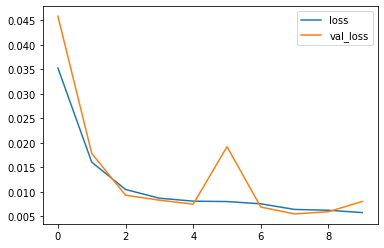

In [320]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Evaluate

In [321]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    # store prediction
    test_predictions.append(current_pred)
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 13ms/step


# Make predictions

In [322]:
true_predictions = scaler.inverse_transform(test_predictions)

In [323]:
test['Predictions'] = true_predictions

/tmp/ipykernel_79/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [324]:
test

sales_amnt   Predictions
date                                
2021-07-01    10290.33  10308.441674
2021-07-02    11028.59  12425.608235
2021-07-03    10793.51  10550.747111
2021-07-04     6524.13   7302.509034
2021-07-05     7983.57   7076.547875
...                ...           ...
2021-12-27     1867.71  10830.751024
2021-12-28     3426.50   8680.280602
2021-12-29     3715.39   9223.601983
2021-12-30     5266.27  10193.079612
2021-12-31     8287.81  13246.835302

[184 rows x 2 columns]

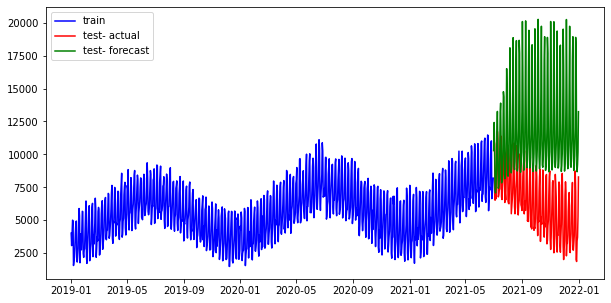

In [325]:
plt.figure(figsize = (10,5))
plt.plot(train, color = 'blue', label = 'train')
plt.plot(test.sales_amnt, color = 'red', label = 'test- actual')
plt.plot(test.index, test.Predictions,color = 'green', label = 'test- forecast')
plt.legend()
plt.show()

test.plot(figsize=(12,8))

## Calculate MAPE

In [327]:
mape_dl = mean_absolute_percentage_error(y_true = test.sales_amnt, y_pred = test.Predictions)
print("MAPE for LSTM : ", mape_dl)

MAPE for LSTM :  1.340662768862336


In [328]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(time_ser)

In [329]:
length = 3*30 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [330]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8


/tmp/ipykernel_79/2856022322.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=8)


1006/1006 [==============================] - 17s 16ms/step - loss: 0.0355
Epoch 2/8
1006/1006 [==============================] - 16s 16ms/step - loss: 0.0090
Epoch 5/8
1006/1006 [==============================] - 16s 16ms/step - loss: 0.0080
Epoch 6/8
1006/1006 [==============================] - 16s 16ms/step - loss: 0.0069
Epoch 7/8
1006/1006 [==============================] - 16s 16ms/step - loss: 0.0056
Epoch 8/8
1006/1006 [==============================] - 16s 16ms/step - loss: 0.0051


In [331]:
forecast = []
periods = 3*30

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    forecast.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 14ms/step


In [332]:
forecast = scaler.inverse_transform(forecast)

In [333]:
forecast_dates = pd.date_range(start='2022-01-01 ',periods=3*30, freq = "D")

In [334]:
forecast_data = pd.DataFrame(data=forecast,index=forecast_dates,
                           columns=['Forecast']).squeeze()

In [335]:
forecast_data

2022-01-01    6319.573530
2022-01-02    2629.123389
2022-01-03    2519.081132
2022-01-04    3141.653457
2022-01-05    3909.282586
                 ...     
2022-03-27    2980.120863
2022-03-28    2510.579918
2022-03-29    3059.443512
2022-03-30    3741.873645
2022-03-31    5003.133172
Freq: D, Name: Forecast, Length: 90, dtype: float64

In [336]:
time_ser

sales_amnt
date                  
2019-01-01     4023.00
2019-01-02     3074.69
2019-01-03     4062.71
2019-01-04     5006.81
2019-01-05     4927.53
...                ...
2021-12-27     1867.71
2021-12-28     3426.50
2021-12-29     3715.39
2021-12-30     5266.27
2021-12-31     8287.81

[1096 rows x 1 columns]

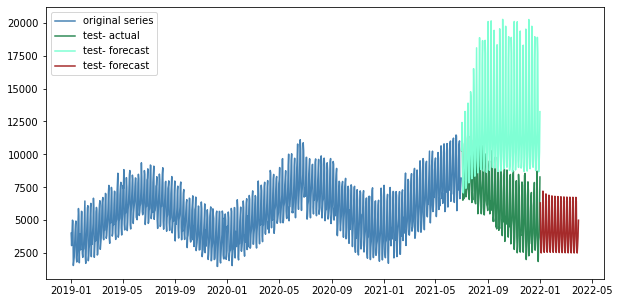

In [337]:
plt.figure(figsize = (10,5))
plt.plot(train.index, train.sales_amnt, color = 'steelblue', label = 'original series')
plt.plot(test.index, test.sales_amnt,color = 'seagreen', label = 'test- actual')
plt.plot(test.index, test.Predictions,color = 'aquamarine', label = 'test- forecast')
plt.plot(forecast_data.index, forecast_data.values, color = 'brown', label = 'test- forecast')
plt.legend()
plt.show()

In [338]:

mape_dl

1.340662768862336

In [339]:

pd.DataFrame([mape_dl ], index = ['LSTM'])

0
LSTM  1.340663